In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn import linear_model

## Lab 1 | Random Forests

In [2]:
numerical = pd.read_csv('numerical.csv')
categorical = pd.read_csv('categorical.csv')
targets = pd.read_csv('target.csv')
data = pd.concat([numerical, categorical, targets], axis = 1)

In [3]:
data.head()

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,STATE,CLUSTER,HOMEOWNR,GENDER,DATASRCE,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B,ODATEW_YR,ODATEW_MM,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM,TARGET_B,TARGET_D
0,0,60.000000,5,9,0,0,39,34,18,10,2,1,5,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,88,8,0,4,96,77,19,13,31,5,14,14,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,27,74,6,14,240.0,31,14,5.0,12.0,10.0,4,7.741935,95515,0,4,39,IL,36,H,F,3,L,E,C,T,2,89,1,37,12,92,8,94,2,95,12,89,11,0,0.0
1,1,46.000000,6,9,16,0,15,55,11,6,2,1,9,3611,940,998,99,0,0,50,50,67,0,0,31,6,4,2,6,4,14,0,0,2,0,1,4,34,41,43,32,42,45,32,33,46,21,13,14,33,23,10,4,2,11,16,36,22,15,12,1,5,4,21,75,55,23,9,69,4,3,24,317,360,99,99,0,0,0,0,0,0,0,5468,5218,12,10,96,4,97,3,9,59,94,88,55,95,5,4,1,3,5,4,2,18,44,5,0,0,0,97,98,98,98,99,94,0,83,76,73,21,5,0,0,0,4,0,0,0,91,91,91,94,4480.0,13.0,803.0,1088,1096,1026,1037,36175,2,6,2,5,15,14,13,10,33,2,5,2,5,15,14,14,10,32,6,2,66,3,56,44,9,80,14,0,0,0,0,0,0,6,0,2,24,32,12,71,70,83,58,81,57,64,57,99,99,0,22,24,4,21,13,2,1,6,0,4,1,0,3,1,0,6,13,1,2,8,18,11,4,3,4,10,7,11,1,6,2,1,16,69,5,2,160,5,5,12,21,7,30,20,14,24,4,24,10,0,0,0,8,15,0,55,10,11,0,0,2,0,3,1,1,2,3,1,1,0,3,0,0,0,42,39,50,7,27,16,99,92,53,5,10,2,26,56,97,99,0,0,0,96,0,4,0,0,0,99,0,99,99,99,20,4,6,5,12,32,6,13,47.0,3,1,10.0,25.0,25.0,18,15.666667,148535,0,2,1,CA,14,H,M,3,L,G,A,S,1,94,1,52,2,93,10,95,12,95,12,93,10,0,0.0
2,1,61.611649,3,1,2,0,20,29,33,6,8,1,1,7001,2040,2669,0,2,98,49,51,96,2,0,0,2,0,0,0,0,0,0,0,2,0,0,0,35,43,46,37,45,49,23,35,40,25,13,20,19,16,13,10,8,15,14,30,22,19,25,10,23,21,35,44,22,6,2,63,9,9,19,183,254,69,69,1,6,5,3,3

In [4]:
data['TARGET_B'].value_counts()

0    90569
1     4843
Name: TARGET_B, dtype: int64

In [5]:
data.shape

(95412, 339)

In [6]:
data.isna().sum().sum()

0

### Train-Test Split

In [7]:
y = data['TARGET_B']
X = data.drop(['TARGET_B','TARGET_D'], axis = 1) 

In [8]:
# do train/test split before Upsampling, and then only Upsample the training set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(66788, 337)
(66788,)
(28624, 337)
(28624,)


### Num-Cat Split

In [10]:
# numericals split
num_train = X_train.select_dtypes(np.number)
num_test = X_test.select_dtypes(np.number)

# numericals transform
from sklearn.preprocessing import MinMaxScaler
transformer = MinMaxScaler().fit(num_train)
num_train_scaled = pd.DataFrame(transformer.transform(num_train), columns=num_train.columns, index=num_train.index)
num_test_scaled = pd.DataFrame(transformer.transform(num_test), columns=num_test.columns, index=num_test.index)

#categoricals split
cat_train= X_train.select_dtypes(object)
cat_test= X_test.select_dtypes(object)

#categoricals transform
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(cat_train)
cat_train_encoded = pd.DataFrame(encoder.transform(cat_train).toarray(), columns=encoder.get_feature_names_out(), index=cat_train.index)
cat_test_encoded = pd.DataFrame(encoder.transform(cat_test).toarray(), columns=encoder.get_feature_names_out(), index=cat_test.index)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(66788, 337)
(66788,)
(28624, 337)
(28624,)


In [12]:
y_train

22676    0
93830    0
31039    0
40854    0
56008    0
        ..
75538    0
56511    0
51833    0
33089    0
74619    0
Name: TARGET_B, Length: 66788, dtype: int64

In [13]:
# num_train_scaled.reset_index(drop = True, inplace = True)
# num_test_scaled.reset_index(drop = True, inplace = True)
# cat_train_encoded.reset_index(drop = True, inplace = True)
# cat_test_encoded.reset_index(drop = True, inplace = True)

In [14]:
X_test = pd.concat([num_test_scaled, cat_test_encoded], axis=1)
X_train = pd.concat([num_train_scaled, cat_train_encoded], axis=1)

In [15]:
X_train

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,CLUSTER,DATASRCE,DOMAIN_B,ODATEW_YR,ODATEW_MM,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM,STATE_FL,STATE_GA,STATE_IL,STATE_IN,STATE_MI,STATE_MO,STATE_NC,STATE_TX,STATE_WA,STATE_WI,STATE_other,HOMEOWNR_U,GENDER_M,GENDER_other,RFA_2A_E,RFA_2A_F,RFA_2A_G,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D,DOMAIN_A_R,DOMAIN_A_S,DOMAIN_A_T,DOMAIN_A_U
22676,0.000000,0.288660,0.833333,0.888889,0.024896,0.000000,0.333333,0.090909,0.474747,0.212121,0.101010,0.050000,0.888889,0.008916,0.011782,0.009491,1.000000,0.000000,0.000000,0.484848,0.525253,1.000000,0.000000,0.000000,0.000000,0.010101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.464286,0.547619,0.583333,0.464286,0.559524,0.607143,0.266667,0.383838,0.373737,0.252525,0.131313,0.171717,0.161616,0.202020,0.30,0.111111,0.080808,0.101010,0.181818,0.313131,0.262626,0.151515,0.272727,0.090909,0.242424,0.161616,0.363636,0.494949,0.232323,0.050505,0.010101,0.686869,0.070707,0.082192,0.191919,0.301538,0.374286,0.919192,0.919192,0.010101,0.030303,0.020202,0.010101,0.000000,0.000000,0.0,0.116500,0.121333,0.230769,0.230769,0.838384,0.171717,0.979798,0.030303,0.000000,0.323232,0.838384,0.717172,0.272727,0.929293,0.080808,0.050505,0.02,0.030303,0.060606,0.181818,0.010101,0.213333,0.626263,0.212121,0.000000,0.000000,0.000000,0.000000,0.010101,0.090909,0.373737,0.878788,0.000000,0.000000,0.707071,0.705882,0.688889,0.245902,0.100,0.030303,0.000000,0.050505,0.101010,0.010101,0.010101,0.040404,0.020202,0.161616,0.545455,0.777778,0.410256,0.330261,0.632236,0.249333,0.263333,0.240667,0.249333,0.070673,0.272727,0.070707,0.090909,0.232323,0.343434,0.000000,0.00,0.000000,0.000000,0.222222,0.111111,0.090909,0.222222,0.373737,0.000000,0.00,0.000000,0.000000,0.303030,0.000000,0.393939,0.101010,0.323232,0.686869,0.030303,0.939394,0.070707,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.060606,0.266667,0.381579,0.050505,0.828283,0.646465,0.757576,0.545455,0.727273,0.515152,0.656566,0.434343,1.000000,0.000000,0.000000,0.171717,0.141414,0.050505,0.131313,0.232323,0.000000,0.109091,0.050505,0.000000,0.060606,0.040404,0.050505,0.020202,0.000000,0.000000,0.020202,0.121212,0.030303,0.000000,0.080808,0.17

### Upsampling

In [16]:
y_train.value_counts()

0    63355
1     3433
Name: TARGET_B, dtype: int64

In [17]:
# temporarily concat X_train and y_train
trainset = pd.concat([X_train, y_train], axis=1)

In [18]:
trainset[trainset['TARGET_B']==1].shape

(3433, 355)

In [19]:
# quick way to upsample category 1:
category_0 = trainset[trainset['TARGET_B']==0]
print(category_0.shape)
category_1 = trainset[trainset['TARGET_B']== 1].sample(len(trainset[trainset['TARGET_B']==0]),replace=True)
print(category_1.shape)

(63355, 355)
(63355, 355)


In [20]:
# concatenate again and shuffle rows
trainset_new = pd.concat([category_0, category_1], axis = 0)
trainset_new = trainset_new.sample(frac =1) #randomize the rows

In [21]:
# X-y split again
X_train_oversampled = trainset_new.drop(['TARGET_B'], axis=1)
y_train_oversampled = trainset_new['TARGET_B']
print(X_train_oversampled.shape)
print(y_train_oversampled.shape)

(126710, 354)
(126710,)


### Apply Random Forest

In [22]:
clf1 = RandomForestClassifier(max_depth=6, 
                             min_samples_split=20, 
                             min_samples_leaf =20,
                             max_samples=0.2, 
                             random_state=42)

clf1.fit(X_train_oversampled, y_train_oversampled)
print(clf1.score(X_train_oversampled, y_train_oversampled))
print(clf1.score(X_test, y_test))

0.6529950280167311
0.6366685299049748


In [23]:
y_pred1 = clf1.predict(X_test)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred1))

0    27214
1     1410
Name: TARGET_B, dtype: int64

array([[17506,  9708],
       [  692,   718]])

### Use Feature Selections that you have learned in class to decide if you want to use all of the features 

#### Feature Selection using Variance Threshold

In [24]:
from sklearn.feature_selection import VarianceThreshold 

# This drops the columns that have a variance less than this threshold
var_threshold = 0.02
sel = VarianceThreshold(threshold=(var_threshold))
sel = sel.fit(X_train)
temp = sel.transform(X_train)
temp = pd.DataFrame(temp)
print(X_train.shape)
print(temp.shape)

(66788, 354)
(66788, 115)


In [25]:
# Get dropped column names
sel.variances_ > var_threshold
sel.get_support()
var_list = list(sel.get_support())
list(zip(X_train.columns, var_list))
colums_dropped = [col[0] for col in zip(X_train.columns, var_list) if col[1] == False]

In [26]:
len(colums_dropped)

239

In [27]:
# drop columns from X_train and X_test

X_train_var = X_train_oversampled.drop(colums_dropped, axis=1).copy()
X_test_var = X_test.drop(colums_dropped, axis=1).copy()
print(X_train_var.shape)
print(X_test_var.shape)

(126710, 115)
(28624, 115)


In [28]:
# Reapply Random Forest
clf2 = RandomForestClassifier(max_depth=6, 
                             min_samples_split=20, 
                             min_samples_leaf =20, 
                             max_samples=0.2, 
                             random_state=42)
clf2.fit(X_train_var, y_train_oversampled)
print(clf2.score(X_train_var, y_train_oversampled))
print(clf2.score(X_test_var, y_test))

0.6518901428458685
0.6259432643935159


In [29]:
y_pred2 = clf2.predict(X_test_var)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred2))

0    27214
1     1410
Name: TARGET_B, dtype: int64

array([[17196, 10018],
       [  689,   721]])

#### Adding Feature Selection with RFE to reduce more columns

In [30]:
# from sklearn.feature_selection import RFE
# lr = LogisticRegression(solver='saga', max_iter=3000)
# rfe = RFE(lr, n_features_to_select=25, verbose=False)
# rfe.fit(X_train_var, y_train_oversampled)
# df = pd.DataFrame(data=rfe.ranking_, columns=['Rank'])
# df['Column_name'] = pd.DataFrame(X_train).columns
# selected_feat_rfe = df[df['Rank']==1].Column_name.tolist()
# rfe=df[df['Rank']==1].Column_name
# rfe.to_csv('rfe.csv', index=False)

In [31]:
rfe = pd.read_csv('rfe.csv')

In [32]:
selected_feat_rfe=rfe.Column_name.tolist()

In [33]:
selected_feat_rfe

['AGEC7',
 'HHAGE3',
 'MARR4',
 'DW9',
 'HV2',
 'HHD6',
 'HHD8',
 'IC11',
 'IC12',
 'IC20',
 'TPE3',
 'LFC2',
 'LFC4',
 'EIC6',
 'OEDC1',
 'SEC1',
 'ANC1',
 'ANC9',
 'ANC12',
 'CARDPROM',
 'CARDGIFT',
 'MINRAMNT',
 'RFA_2F',
 'ODATEW_YR',
 'MINRDATE_YR']

In [34]:
len(selected_feat_rfe)

25

In [35]:
# drop columns from X_train and X_test
X_train_rfe = X_train_oversampled[selected_feat_rfe]
X_test_rfe = X_test[selected_feat_rfe]
print(X_train_rfe.shape)
print(X_test_rfe.shape)

(126710, 25)
(28624, 25)


In [36]:
# Reapply Random Forest
clf3 = RandomForestClassifier(max_depth=7, 
                             min_samples_leaf=20, 
                             min_samples_split=20, 
                             max_samples=0.5,
                             random_state=42)
clf3.fit(X_train_rfe, y_train_oversampled)
print(clf3.score(X_train_rfe, y_train_oversampled))
print(clf3.score(X_test_rfe, y_test))

y_pred3 = clf3.predict(X_test_rfe)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred3))

0.6595690947833636
0.6312185578535495


0    27214
1     1410
Name: TARGET_B, dtype: int64

array([[17350,  9864],
       [  692,   718]])

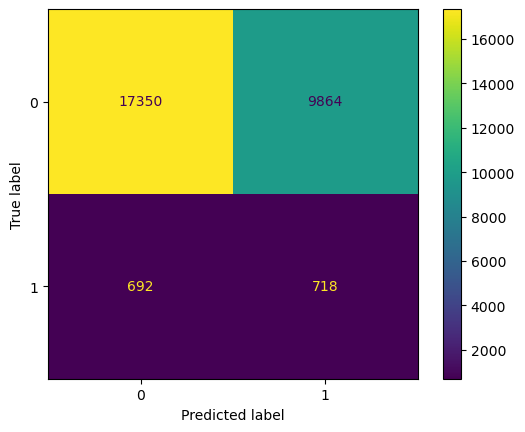

In [37]:
cm = confusion_matrix(y_test, y_pred3)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf3.classes_).plot()
plt.show()

### Predicting for whole dataframe

In [38]:
#Num-Cat Split
numericalX = X.select_dtypes(np.number)
categoricalX = X.select_dtypes(object) 

#Scaling
num_scaled = pd.DataFrame(transformer.transform(numericalX), columns=numericalX.columns, index=numericalX.index)

#Encoding
cat_encoded = pd.DataFrame(encoder.transform(categoricalX).toarray(), columns=encoder.get_feature_names_out(), index=categoricalX.index)

#Concatenate
X_all = pd.concat([num_scaled,cat_encoded], axis=1)

#Drop columns from feature selection
X_selected = X_all.drop(columns=[col for col in X_all if col not in selected_feat_rfe]).copy()

In [39]:
#Predictions
predictions = clf3.predict(X_selected)
display(confusion_matrix(y, predictions))

array([[58166, 32403],
       [ 1840,  3003]])

In [40]:
print(clf3.score(X_selected, y))
print(precision_score(y,predictions))
print(recall_score(y,predictions))
print(f1_score(y,predictions))

0.6411038443801618
0.08481613285883749
0.6200702044187487
0.1492210986608363


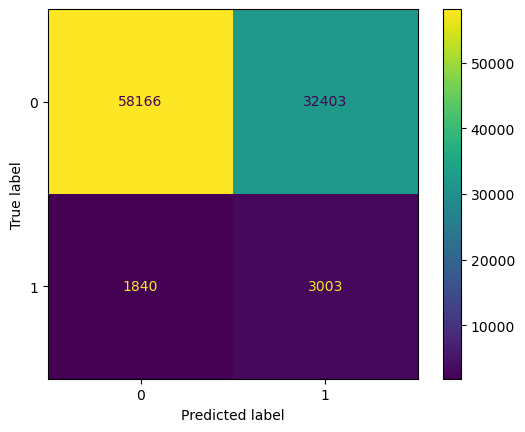

In [41]:
cm2 = confusion_matrix(y, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=clf3.classes_).plot()
plt.show()

In [43]:
data['PREDICTED_DONATE'] = clf3.predict(X_selected)
data2 = data.copy()

In [44]:
data['PREDICTED_DONATE'].value_counts()

0    60006
1    35406
Name: PREDICTED_DONATE, dtype: int64

### Prediction Probabilities

In [45]:
clf3.predict_proba(X_selected)

array([[0.42239162, 0.57760838],
       [0.54284829, 0.45715171],
       [0.38834117, 0.61165883],
       ...,
       [0.47765382, 0.52234618],
       [0.3692971 , 0.6307029 ],
       [0.51524838, 0.48475162]])

In [46]:
clf3.predict(X_selected)

array([1, 0, 1, ..., 1, 1, 0])

In [47]:
data['TARGET_B'].value_counts()

0    90569
1     4843
Name: TARGET_B, dtype: int64

In [48]:
def my_pred(model, features, labels, cutoff): # make sure labels match the order of the proba columns
    probas = model.predict_proba(features)
    preds = [labels[1] if proba[1]>cutoff else labels[0] for proba in probas]
    return preds

In [65]:
pred_over_cutoff = my_pred(clf3, X_selected, [0, 1], 0.55)

In [66]:
data['PRED_OVER_CUTOFF'] = pred_over_cutoff

In [67]:
data['PRED_OVER_CUTOFF'].value_counts()

0    76010
1    19402
Name: PRED_OVER_CUTOFF, dtype: int64

In [68]:
print(clf3.score(X_selected, y))
print(precision_score(y,pred_over_cutoff))
print(recall_score(y,pred_over_cutoff))
print(f1_score(y,pred_over_cutoff))

0.6411038443801618
0.10375219049582517
0.4156514557092711
0.16605485667147862


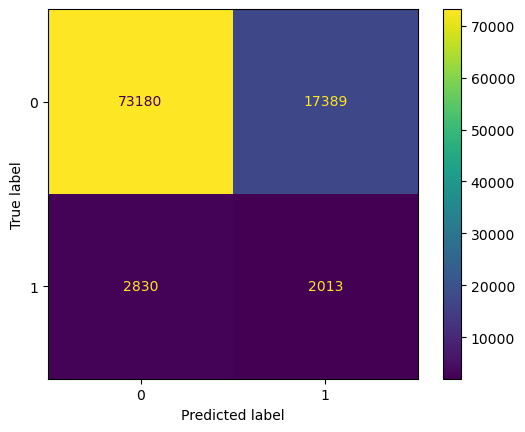

In [69]:
cm3 = confusion_matrix(y, pred_over_cutoff)
ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=clf3.classes_).plot()
plt.show()

### Analysis 1

In [58]:
data[data['TARGET_B']==1]['TARGET_D'].mean()

15.624344414619037

In [74]:
#Got from Erin

array = confusion_matrix(y, predictions)
S1 = array[0][0]
S2 = array[0][1]
S3 = array[1][0]
S4 = array[1][1]

donation_gained = S4 * 15.6
unexpected_donation = S3 * 15.6
marketing_cost = (S4+S2) * 0.68
no_return_marketing = S2 * 0.68
overall_revenue1 = (donation_gained + unexpected_donation) - marketing_cost

print('Donation amount gained:',round(donation_gained,2))
print('Unexpected Donations:',round(unexpected_donation,2))
print('Amount spent (cost) on marketing:',round(marketing_cost,2))
print('Amount lost on marketing:',round(no_return_marketing,2))
print('Overall revenue (donation - cost):',round(overall_revenue1,2))

Donation amount gained: 46846.8
Unexpected Donations: 28704.0
Amount spent (cost) on marketing: 24076.08
Amount lost on marketing: 22034.04
Overall revenue (donation - cost): 51474.72


### Analysis 2: Using predict_proba cutoff

In [75]:
array = confusion_matrix(y, pred_over_cutoff)
S1 = array[0][0]
S2 = array[0][1]
S3 = array[1][0]
S4 = array[1][1]

donation_gained = S4 * 15.6
unexpected_donation = S3 * 15.6
marketing_cost = (S4+S2) * 0.68
no_return_marketing = S2 * 0.68
overall_revenue2 = (donation_gained + unexpected_donation) - marketing_cost

print('Donation amount gained:',round(donation_gained,2))
print('Unexpected Donations:',round(unexpected_donation,2))
print('Amount spent (cost) on marketing:',round(marketing_cost,2))
print('Amount lost on marketing:',round(no_return_marketing,2))
print('Overall revenue (donation - cost):',round(overall_revenue2,2))

Donation amount gained: 31402.8
Unexpected Donations: 44148.0
Amount spent (cost) on marketing: 13193.36
Amount lost on marketing: 11824.52
Overall revenue (donation - cost): 62357.44


In [76]:
# Difference in revenues of both models

overall_revenue2 - overall_revenue1

10882.720000000016

## Lab 2 | Final regression model 

In [77]:
donors = data.loc[data['TARGET_B']==1].reset_index(drop=True)

In [78]:
donors.shape

(4843, 341)

In [79]:
donors.head()

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,STATE,CLUSTER,HOMEOWNR,GENDER,DATASRCE,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B,ODATEW_YR,ODATEW_MM,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM,TARGET_B,TARGET_D,PREDICTED_DONATE,PRED_OVER_CUTOFF
0,2,62.000000,3,8,10,2,25,40,27,11,4,1,9,2707,672,929,99,0,0,45,55,97,1,0,2,1,0,0,0,0,1,0,0,1,0,0,0,35,42,43,37,47,50,27,34,43,23,9,20,27,16,8,6,15,15,13,37,21,14,16,8,15,23,30,47,29,11,2,55,10,13,22,190,267,89,49,1,10,10,8,8,8,0,902,960,8,8,88,12,97,3,11,42,72,60,34,79,21,8,1,7,12,21,5,21,58,17,0,1,0,0,4,35,74,99,0,1,64,63,62,14,4,2,8,0,5,1,7,0,95,96,96,96,5120.0,107.0,613.0,468,501,540,580,20328,6,8,19,23,23,11,7,1,2,4,6,13,27,25,14,8,1,1,14,2,66,1,61,39,20,74,17,2,2,0,0,0,2,4,1,75,20,21,1,67,71,82,62,80,60,80,65,99,0,1,21,20,8,11,17,1,1,10,0,5,3,2,1,0,0,3,23,5,2,4,12,7,3,2,1,14,12,7,5,11,4,1,4,70,10,0,140,5,3,24,21,9,32,7,3,23,3,16,7,1,2,0,12,25,3,40,20,27,7,0,0,2,12,0,0,3,1,4,1,0,0,0,4,0,1,58,95,1,0,4,95,69,23,4,13,2,17,35,91,99,1,12,3,93,0,5,1,0,1,99,1,97,99,99,9,2,6,3,26,65,5,12,61.0,15,10,2.0,7.0,5.0,12,4.066667,82943,1,3,3,other,12,H,F,3,L,D,A,S,1,87,1,36,1,88,1,94,4,96,3,87,1,1,4.0,1,1
1,0,61.611649,5,9,0,1,37,58,16,8,1,5,9,2147,591,640,99,0,0,49,51,94,2,0,3,5,1,0,1,1,0,0,0,3,0,0,2,29,36,37,27,38,40,37,46,37,17,8,34,34,15,6,2,1,18,21,31,19,11,5,0,3,7,23,71,47,15,6,77,5,1,17,286,334,99,99,0,0,0,0,0,0,0,1002,1166,7,5,97,3,96,4,3,63,92,88,59,97,3,4,1,3,5,4,1,30,60,4,1,2,0,4,15,50,94,99,2,0,91,70,72,20,4,0,0,0,3,0,0,0,78,83,99,99,2920.0,201.0,618.0,633,638,652,663,19703,2,5,1,17,48,19,7,0,1,3,4,0,16,51,19,7,0,1,5,0,65,3,74,26,25,89,9,0,0,0,0,0,1,2,1,82,34,42,22,70,82,98,67,97,66,68,61,99,99,0,34,23,4,10,12,0,2,9,0,4,1,1,0,0,4,2,25,5,2,4,8,8,8,0,3,10,8,9,4,8,1,5,5,76,4,1,160,0,1,12,25,10,39,13,5,33,6,25,7,1,1,0,19,37,2,58,11,16,10,0,4,1,15,0,0,3,2,0,2,0,0,0,1,0,3,48,97,1,1,1,99,91,24,3,6,6,57,85,95,95,5,0,0,75,0,20,0,0,5,96,4,90,99,99,12,4,1,6,10,24,0,2,68.0,11,6,2.0,10.0,7.0,9,6.181818,190313,1,3,14,TX,35,H,M,3,L,D,A,T,1,90,1,0,2,90,4,93,1,95,12,90,4,1,7.0,1,1
2,0,66.000000,5,9,5,0,33,24,39,6,5,1,9,2160,683,900,89,0,11,48,52,99,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,42,47,49,40,48,50,20,33,42,25,7,14,23,21,17,13,5,14,13,33,22,18,24,7,22,22,43,35,19,6,1,72,7,5,16,165,240,69,

In [80]:
X = donors.drop(['TARGET_B','TARGET_D','PREDICTED_DONATE','PRED_OVER_CUTOFF'], axis = 1) 
y = donors['TARGET_D']

### Train-Test Split and Num-Cat Split

In [81]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# numericals split
num_train = X_train.select_dtypes(np.number)
num_test = X_test.select_dtypes(np.number)

# numericals transform
from sklearn.preprocessing import MinMaxScaler
transformer2 = MinMaxScaler().fit(num_train)
num_train_scaled = pd.DataFrame(transformer2.transform(num_train), columns=num_train.columns, index=num_train.index)
num_test_scaled = pd.DataFrame(transformer2.transform(num_test), columns=num_test.columns, index=num_test.index)

#categoricals split
cat_train= X_train.select_dtypes(object)
cat_test= X_test.select_dtypes(object)

#categoricals transform
from sklearn.preprocessing import OneHotEncoder
encoder2 = OneHotEncoder(handle_unknown='error', drop='first').fit(cat_train)
cat_train_encoded = pd.DataFrame(encoder2.transform(cat_train).toarray(), columns=encoder2.get_feature_names_out(), index=cat_train.index)
cat_test_encoded = pd.DataFrame(encoder2.transform(cat_test).toarray(), columns=encoder2.get_feature_names_out(), index=cat_test.index)

In [82]:
# Concatenate data
X_test = pd.concat([num_test_scaled, cat_test_encoded], axis=1)
X_train = pd.concat([num_train_scaled, cat_train_encoded], axis=1)

### Modeling

In [83]:
#We will use Random Forest Regressor
rfr = RandomForestRegressor(max_depth=6,
                             min_samples_split=50,
                             min_samples_leaf =50,
                             max_samples=0.7)

rfr.fit(X_train, y_train)
print(rfr.score(X_train, y_train))
print(rfr.score(X_test, y_test))

0.523965382721276
0.4464443768828529


### Predict on data

In [84]:
#Num-Cat Split
numericalX = X.select_dtypes(np.number)
categoricalX = X.select_dtypes(object) 

#Scaling
num_scaled = pd.DataFrame(transformer2.transform(numericalX), columns=numericalX.columns, index=numericalX.index)

#Encoding
cat_encoded = pd.DataFrame(encoder2.transform(categoricalX).toarray(), columns=encoder2.get_feature_names_out(), index=categoricalX.index)

#Concatenate
X_treated = pd.concat([num_scaled, cat_encoded], axis=1)

In [85]:
#Predictions
donors['PRED_DONATION'] = rfr.predict(X_treated)

In [86]:
print(rfr.score(X_treated, y))

0.5057385818330418


In [87]:
display(donors['TARGET_D'].mean())
display(donors['PRED_DONATION'].mean())

15.624344414619037

15.519106566363071

### Make predictions on those predicted to donate

In [88]:
predicted_donors = data2.loc[data2['PREDICTED_DONATE']==1].reset_index(drop=True)

In [89]:
Xpred = predicted_donors.drop(['TARGET_B','TARGET_D','PREDICTED_DONATE'], axis = 1) 

In [90]:
#Num-Cat Split
numerical = Xpred.select_dtypes(np.number)
categorical = Xpred.select_dtypes(object) 

#Scaling
scaled_num = pd.DataFrame(transformer2.transform(numerical), columns=numerical.columns, index=numerical.index)

#Encoding
encoded_cat = pd.DataFrame(encoder2.transform(categorical).toarray(), columns=encoder2.get_feature_names_out(), index=categorical.index)

#Concatenate
All_X = pd.concat([scaled_num,encoded_cat], axis=1)

In [91]:
#Predictions
predicted_donors['PRED_DONATION'] = rfr.predict(All_X)

In [92]:
predicted_donors.head(5)

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,STATE,CLUSTER,HOMEOWNR,GENDER,DATASRCE,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B,ODATEW_YR,ODATEW_MM,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM,TARGET_B,TARGET_D,PREDICTED_DONATE,PRED_DONATION
0,0,60.000000,5,9,0,0,39,34,18,10,2,1,5,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,88,8,0,4,96,77,19,13,31,5,14,14,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,27,74,6,14,240.0,31,14,5.0,12.0,10.0,4,7.741935,95515,0,4,39,IL,36,H,F,3,L,E,C,T,2,89,1,37,12,92,8,94,2,95,12,89,11,0,0.0,1,10.621009
1,1,61.611649,3,1,2,0,20,29,33,6,8,1,1,7001,2040,2669,0,2,98,49,51,96,2,0,0,2,0,0,0,0,0,0,0,2,0,0,0,35,43,46,37,45,49,23,35,40,25,13,20,19,16,13,10,8,15,14,30,22,19,25,10,23,21,35,44,22,6,2,63,9,9,19,183,254,69,69,1,6,5,3,3,3,0,497,546,2,1,78,22,93,7,18,36,76,65,30,86,14,7,2,5,11,17,3,17,60,18,0,1,0,0,1,6,18,50,0,4,36,49,51,14,5,4,2,24,11,2,3,6,0,2,9,44,0.0,281.0,518.0,251,292,292,340,11576,32,18,20,15,12,2,0,0,1,20,19,24,18,16,2,0,0,1,28,8,31,11,38,62,8,74,22,0,0,0,0,0,2,2,1,21,19,24,6,61,65,73,59,70,56,78,62,82,99,4,10,5,2,6,12,0,1,9,5,18,20,5,7,6,0,11,33,4,3,2,12,3,3,2,0,7,8,3,3,6,7,1,8,74,3,1,120,22,20,28,16,6,5,3,1,23,1,16,6,0,0,0,10,21,0,28,23,32,8,1,14,1,5,0,0,7,0,0,0,0,0,1,0,0,2,84,96,3,0,0,92,65,29,9,22,3,12,23,50,69,31,0,0,0,6,35,44,0,15,22,77,17,97,92,9,2,6,5,26,63,6,14,202.0,27,14,2.0,16.0,5.0,12,7.481481,15078,1,4,60,NC,43,U,M,3,L,E,C,R,2,90,1,0,2,91,11,92,7,95,12,90,1,0,0.0,1,8.799230
2,0,70.000000,1,4,2,0,23,14,31,3,0,3,0,640,160,219,0,8,92,54,46,61,0,0,11,32,6,2,0,0,0,0,0,31,0,0,1,32,40,44,34,43,47,25,45,35,20,15,25,17,17,12,7,7,20,17,30,14,19,25,11,23,23,27,5

In [93]:
display(predicted_donors['PRED_DONATION'].mean())

13.509003895771066

In [ ]:
# concatenate xtrain and ytrain, run model on all your data
# Get a list of people who are likely to donate, who we predicted will donate.
# For those that we predicted will donate, get a prediction of how much they will donate
# And subtract from their predicted donation, how much it takes to mail to them
# predict_proba(used on people we classified who will and will not donate): give you for each row, two values(prob that outcome will be 0 and 1)
# what probability did the classifier give them that they will donate or not donate
# Use model on predicted to donate to find out how much
# When we send flyers out we want to know how much they will give us.
# Make predictions where predicted donate == 1